# U.S. Dollar Index: ARCH/GARCH Volatility Modelling

The trade-weighted US dollar index, also known as the broad index, is a measure of the value of the United States dollar relative to other world currencies. It is a trade weighted index that improves on the older U.S. Dollar Index by using more currencies and the updating the weights yearly (rather than never). The base index value is 100 in Jan 1997.
https://en.wikipedia.org/wiki/Trade-weighted_US_dollar_index

 [](http://)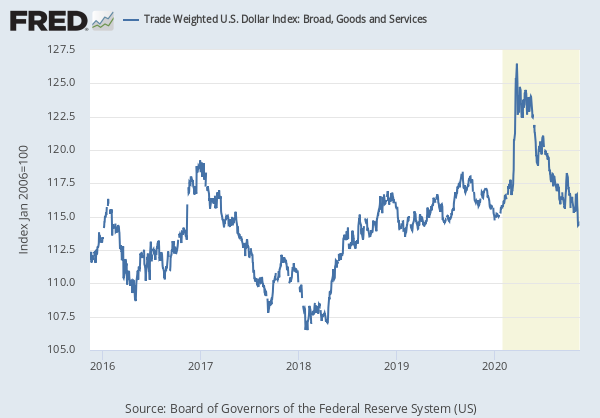

## Import Libraries

In [14]:
%matplotlib inline

import os
import sys
import warnings
from datetime import date

import pandas as pd
import pandas_datareader.data as web

import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller

from sklearn.metrics import mean_squared_error

from scipy.stats import probplot, moment

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [15]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### Import Data

In [16]:
dollar = web.DataReader('DTWEXBGS', 'fred', '2015', '2020-10-30').squeeze()
dollar_returns = np.log(dollar).diff().dropna().mul(100) # rescale to faciliate optimization

In [17]:
dollar.head()

DATE
2015-01-01         NaN
2015-01-02    102.8979
2015-01-05    103.4920
2015-01-06    103.2871
2015-01-07    103.6230
Name: DTWEXBGS, dtype: float64

In [18]:
dollar_returns.head()

DATE
2015-01-05    0.575708
2015-01-06   -0.198183
2015-01-07    0.324682
2015-01-08   -0.340755
2015-01-09   -0.154374
Name: DTWEXBGS, dtype: float64

## Exploratory Data Analysis (EDA): Explore Returns and Volatility

In [19]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

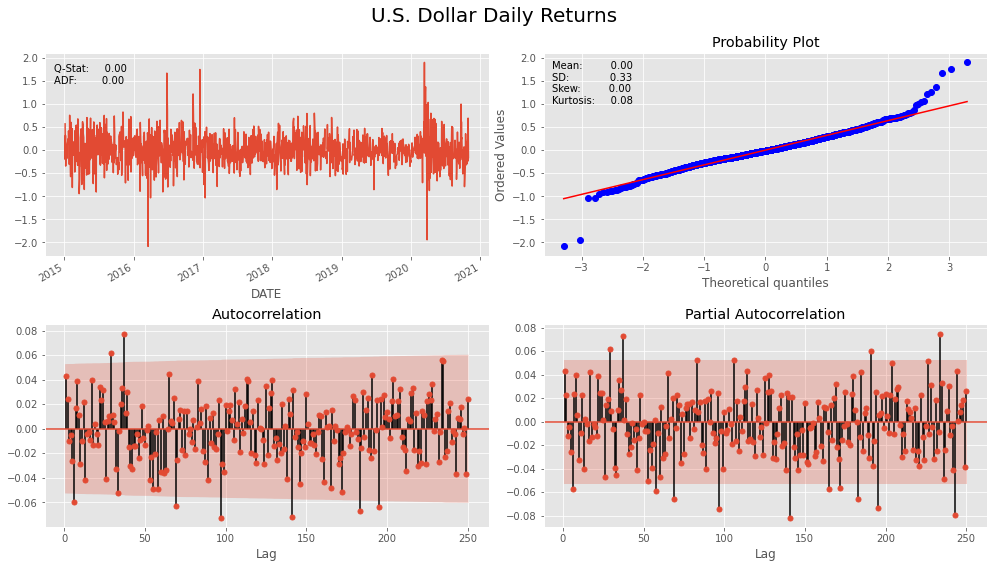

In [20]:
plot_correlogram(dollar_returns, lags=250, title='U.S. Dollar Daily Returns')

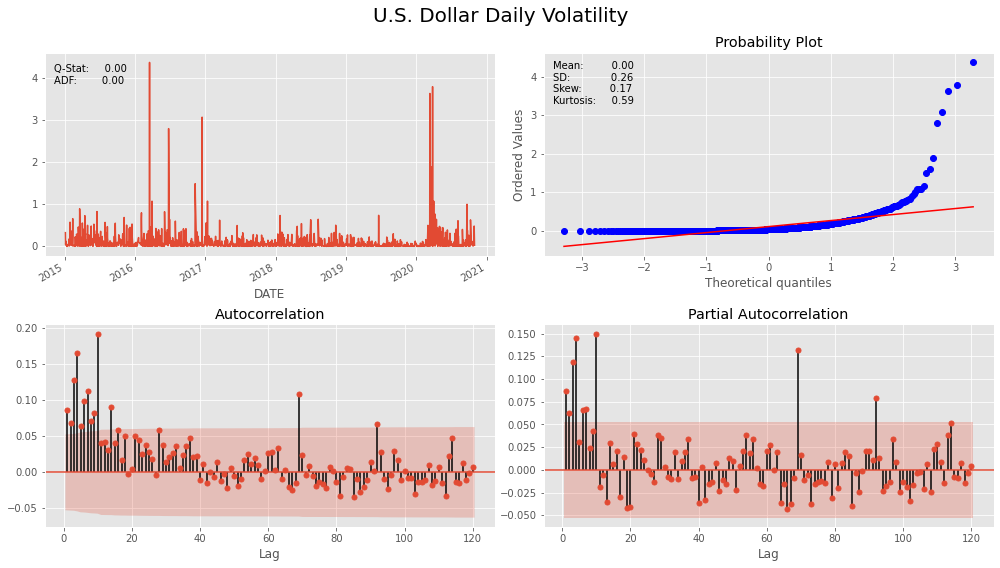

In [21]:
plot_correlogram(dollar_returns.sub(dollar_returns.mean()).pow(2), lags=120, title='U.S. Dollar Daily Volatility')

## Modelling: rolling out-of-sample forecast

In [22]:
# trainsize = 10 * 252  # 10 years
trainsize = 5 * 252 # 5 years
data = dollar_returns.clip(lower=dollar_returns.quantile(.05),
                           upper=dollar_returns.quantile(.95))
T = len(dollar_returns)
test_results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        test_results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


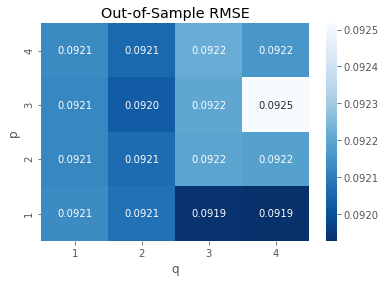

In [23]:
s = pd.Series(test_results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)
sns.heatmap(s, cmap='Blues_r', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');

### Estimating GARCH(2, 2) Model

In [24]:
am = ConstantMean(dollar_returns.clip(lower=dollar_returns.quantile(.05),
                                      upper=dollar_returns.quantile(.95)))
am.volatility = GARCH(2, 0, 2)
am.distribution = Normal()
model = am.fit(update_freq=5)
print(model.summary())

Iteration:      5,   Func. Count:     51,   Neg. LLF: 120.7755746762613
Iteration:     10,   Func. Count:     96,   Neg. LLF: 120.53022663094089
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 120.52159911286742
            Iterations: 14
            Function evaluations: 130
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               DTWEXBGS   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -120.522
Distribution:                  Normal   AIC:                           253.043
Method:            Maximum Likelihood   BIC:                           284.457
                                        No. Observations:                 1388
Date:                Tue, Nov 17 2020   Df Residuals:                     1382
Time:      

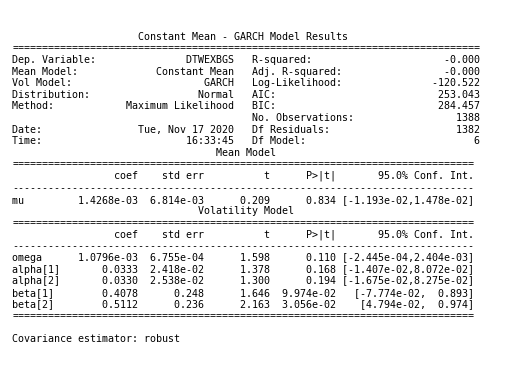

In [25]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('garch_summary.png', bbox_inches='tight', dpi=300);

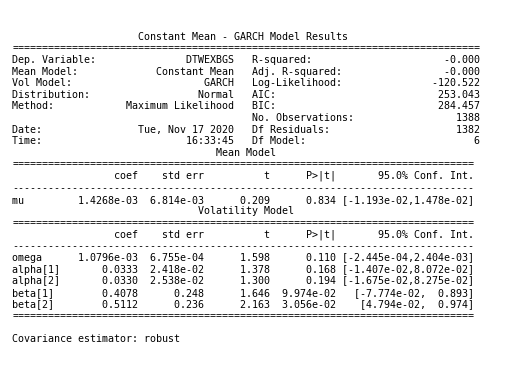

In [26]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('garch_model_summary.png', bbox_inches='tight', dpi=300);

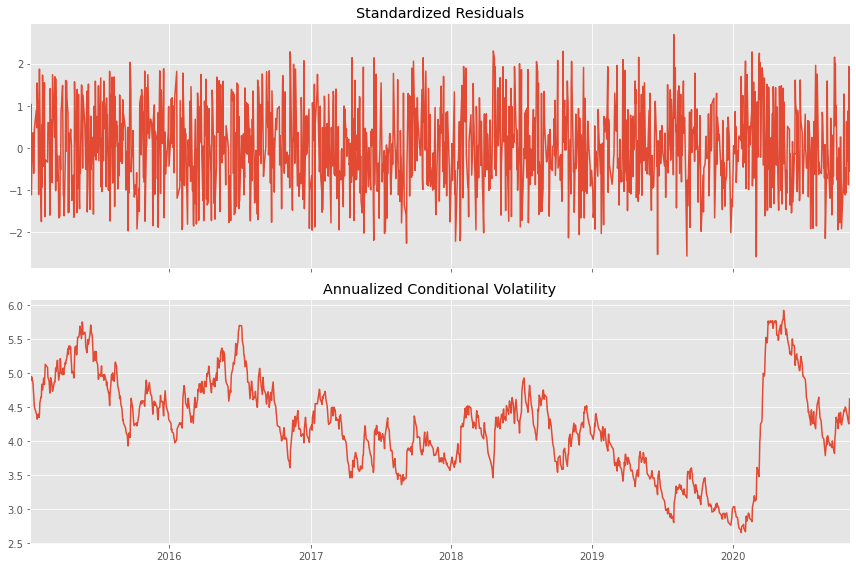

In [27]:
fig = model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout();

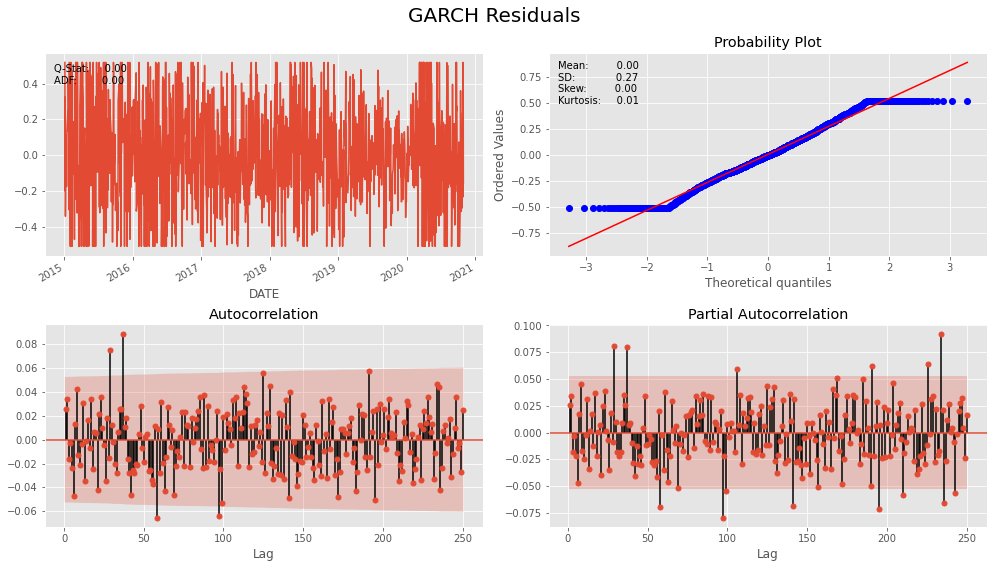

In [28]:
plot_correlogram(model.resid.dropna(), lags=250, title='GARCH Residuals')

Reference: Stefan Jansen; Wikipedia